In [1]:
# Hack to import helper packages
%cd /workspaces/segment_vasculature/models/

/workspaces/segment_vasculature/models


In [2]:
from helpers.loss_functions import DiceLoss
from helpers.train_test import train_and_test
from helpers.dataset_setup import train_test_split, augment_image, DataLoader, TRAIN_FOLDER, preprocess_image, preprocess_mask

from resnet import resnet50, resnet10

import os
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
import cv2
#import wandb
from skimage.transform import resize as skresize
#wandb.login()

In [3]:
image_folder = f'{TRAIN_FOLDER}/kidney_2/images/'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".tif")]
image_files.sort()
labels_folder = f'{TRAIN_FOLDER}/kidney_2/labels/'
label_files = [os.path.join(labels_folder, img) for img in os.listdir(labels_folder) if img.endswith(".tif")]
label_files.sort()

In [4]:
def preprocess_image(paths: list[str]) -> torch.Tensor:
    imgs = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # img = np.tile(img[...,None],[1,1,3])
        img = img.astype('float32')
        mx = np.max(img)
        if mx:
            img/=mx
        # img = np.transpose(img,(2,0,1))
        imgs.append(torch.tensor(img))
    img_ten = torch.stack(imgs)
    return img_ten

def preprocess_mask(paths: list[str]) -> torch.Tensor:
    msks = []
    for path in paths:
        msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        msk = msk.astype('float32')
        msk/=255.0
        msks.append(torch.tensor(msk))
    msk_ten = torch.stack(msks)
    return msk_ten

In [12]:
class SenNetDataset(Dataset):

    def __init__(self, image_files: list[str], mask_files, input_size=(16, 256, 256), augmentation_transforms=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_D = input_size[0]
        self.input_H = input_size[1]
        self.input_W = input_size[2]
        self.augmentation_transforms=augmentation_transforms
        self.iter = 0
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        print("idx: ", idx)
        image_paths = self.image_files[idx]
        mask_paths = self.mask_files[idx]
        # Extract images into tensor
        images = preprocess_image(image_paths)
        masks = preprocess_mask(mask_paths)
        img_size = list(images.size())
        mask_size = list(masks.size())
        assert img_size[0] == mask_size[0], "img size:{} is not equal to mask size:{}".format(img_size, mask_size)
        
        print(f"Image shape: {images.shape}")
        print(f"Mask shape: {masks.shape}")
        images = images.reshape((1, img_size[0], img_size[1], img_size[2]))
        masks = masks.reshape((1, mask_size[0], mask_size[1], mask_size[2]))
        print(f"Image shape: {images.shape}")
        print(f"Mask shape: {masks.shape}")
        images, masks = self.__training_data_process__(images, masks)
        
        if self.augmentation_transforms:
            image, mask=self.augmentation_transforms(image, mask, self.input_size)

        print(f"Image shape: {images.shape}")
        print(f"Mask shape: {masks.shape}")
        return images, masks

    def __drop_invalid_range__(self, volume, label=None):
        """
        Cut off the invalid area
        """
        zero_value = volume[0, 0, 0]
        non_zeros_idx = np.where(volume != zero_value)
        
        [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
        [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)
        
        if label is not None:
            return volume[min_z:max_z, min_h:max_h, min_w:max_w], label[min_z:max_z, min_h:max_h, min_w:max_w]
        else:
            return volume[min_z:max_z, min_h:max_h, min_w:max_w]



    def __itensity_normalize_one_volume__(self, volume: np.ndarray) -> torch.Tensor:
        """
        normalize the itensity of an nd volume based on the mean and std of non-zero region
        inputs:
            volume: the input nd volume
        outputs:
            out: the normalized nd volume
        """
        
        pixels = volume[volume > 0]
        mean = pixels.mean()
        std  = pixels.std()
        out = (volume - mean)/std
        out_random = np.random.normal(0, 1, size = volume.shape)
        out[volume == 0] = out_random[volume == 0]
        return torch.from_numpy(out)

    def __resize_data__(self, data: torch.Tensor, label=False) -> np.ndarray:
        """
        Resize the data to the input size
        """ 
        #scale = [self.input_D*1.0/depth, self.input_H*1.0/height, self.input_W*1.0/width]
        np_data = data.numpy()
        if label:
            data: np.ndarray = skresize(np_data, (1, self.input_D, self.input_H, self.input_W))
        else:
            data: np.ndarray = skresize(np_data, (1, self.input_D, self.input_H, self.input_W))
        
        return data


    def __crop_data__(self, data, label):
        """
        Random crop with different methods:
        """ 
        # random center crop
        data, label = self.__random_center_crop__ (data, label)
        
        return data, label

    def __training_data_process__(self, data: torch.Tensor, label: torch.Tensor): 
        # crop data according net input size
        # data = data.get_data()
        # label = label.get_data()
        
        # drop out the invalid range
        #data, label = self.__drop_invalid_range__(data, label)
        
        # crop data
        #data, label = self.__crop_data__(data, label) 

        # resize data
        data = self.__resize_data__(data, label=False)
        label = self.__resize_data__(label, label=True)
        # normalization datas
        # NOTE: Something drops the required_grad flag here, maybe int casting?
        data = self.__itensity_normalize_one_volume__(data)
        # label = torch.from_numpy(label)
        data.requires_grad = True
        return data, label

In [13]:
# Chunk the data into the desired depth of the 3d image
_3d_image_depth = 8
_3d_images = []
_3d_labels = []
for i in range(0, len(image_files), _3d_image_depth):
    # TODO: if we need more images, we can slide the window by 1 instead of 16
    # Extract images into tensor
    images = image_files[i:(i+_3d_image_depth)]
    masks = label_files[i:(i+_3d_image_depth)]
    _3d_images.append(images)
    _3d_labels.append(masks)


In [14]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    _3d_images, _3d_labels, test_size=0.1, shuffle=False)

input_dims = (768, 768)

train_dataset = SenNetDataset(train_image_files, train_mask_files, input_size=(_3d_image_depth, input_dims[0], input_dims[1]))
val_dataset = SenNetDataset(val_image_files, val_mask_files, input_size=(_3d_image_depth, input_dims[0], input_dims[1]))

train_dataloader= DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [15]:
from torch import nn

In [34]:
class MedicalNet(nn.Module):

  def __init__(self, path_to_weights, device, kw):
    super(MedicalNet, self).__init__()
    self.model = resnet10(**kw)
    num_seg_classes = kw['num_seg_classes']
    self.model.conv_seg = nn.Sequential(
        nn.ConvTranspose3d(
          in_channels=512,
          out_channels=256,
          stride=(2, 2, 2),
          padding=(1, 1, 1),
          dilation=(1, 2, 2),
          kernel_size=(3, 2, 2),
          output_padding=(1, 1, 1),
        ),
        nn.BatchNorm3d(256),
        nn.ReLU(inplace=True),
        nn.ConvTranspose3d(
          in_channels=256,
          out_channels=64,
          stride=(2, 2, 2),
          padding=(1, 1, 1),
          dilation=(2, 2, 2),
          kernel_size=(4, 2, 2),
          output_padding=(1, 1, 1),
        ),
        nn.BatchNorm3d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose3d(
          in_channels=64,
          out_channels=num_seg_classes,
          stride=(1, 2, 2),
          padding=(1, 1, 1),
          dilation=(1, 2, 2),
          kernel_size=(3, 2, 2),
          output_padding=(0, 1, 1),
        ),
    )
    net_dict = self.model.state_dict()
    pretrained_weights = torch.load(path_to_weights, map_location=torch.device(device))
    pretrain_dict = {
        k.replace("module.", ""): v for k, v in pretrained_weights['state_dict'].items() if k.replace("module.", "") in net_dict.keys()
      }
    net_dict.update(pretrain_dict)
    self.model.load_state_dict(net_dict)

  def forward(self, x: torch.Tensor):
    x = self.model(x)
    return x

In [35]:
# run = wandb.init(
#     project="custom_seg_vasculature",
#     config={
#         "architechture": "pretrained_resnet50",
#         "optimizer": "ADAM",
#     }
# )

In [36]:
epochs = 10
def train():
    kw = {'sample_input_D': _3d_image_depth, 'sample_input_H': input_dims[0], 'sample_input_W': input_dims[1], 'num_seg_classes': 1}
    model = MedicalNet('tencent_model/pretrain/resnet_10.pth', device="cuda", kw=kw)
    

    for k, v in model.named_parameters():
        if k.startswith("conv_seg"):
            v.requires_grad = True
        else:
            v.requires_grad = False

    #run.watch(models=model, log="all")
    optimizer = torch.optim.Adam(model.parameters())
    criterion = DiceLoss()
    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, w_b=False, num_epochs=epochs, show_images=False)
    return trained_model, train_epoch_losses, test_epoch_losses


trained_model, train_epoch_losses, test_epoch_losses = train()
#torch.save(trained_model.state_dict(), 'lower_learning_rate_100.pth')
 
# input: (1, 1, z, x, y)
# output looks like: (1, 1, 2, x/4, y/4)

Epoch 1/10
----------
idx:  0
Image shape: torch.Size([8, 1041, 1511])
Mask shape: torch.Size([8, 1041, 1511])
Image shape: torch.Size([1, 8, 1041, 1511])
Mask shape: torch.Size([1, 8, 1041, 1511])
Image shape: torch.Size([1, 8, 768, 768])
Mask shape: (1, 8, 768, 768)
Input before forward: torch.Size([1, 1, 8, 768, 768])
After conv1 shape: torch.Size([1, 64, 4, 384, 384])
maxpool shape: torch.Size([1, 64, 2, 192, 192])
layer4 shape: torch.Size([1, 512, 1, 96, 96])
After conv_seg shape: torch.Size([1, 1, 8, 768, 768])
Predicted Mask shape: torch.Size([1, 1, 8, 768, 768])
Mask shape: torch.Size([1, 1, 8, 768, 768])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

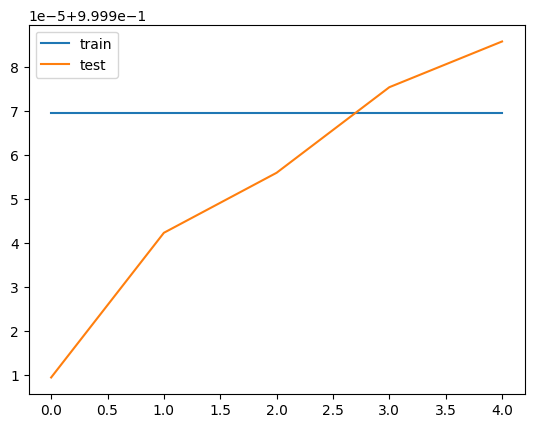

In [ ]:
# run.finish()
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_epoch_losses, label="train")
plt.plot(test_epoch_losses, label="test")
plt.legend()
plt.show()